# IMPORT LIBRARIES

In [11]:
import cv2 as cv
import os
from tensorflow.keras.preprocessing.image import DirectoryIterator, ImageDataGenerator
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from skimage.filters import prewitt_h,prewitt_v
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from random import sample

##### ILLUSTRATION OF KEYPOINTS WITH SIFT OPENCV

More info here (https://docs.opencv.org/master/da/df5/tutorial_py_sift_intro.html)

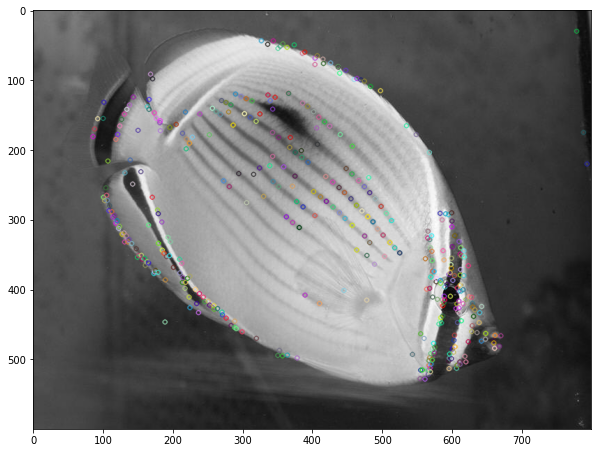

In [20]:
#detection of keypoints
img1 = cv.imread('../catchafish/data/fish_05/wpdim9cb.jpg')
gray1 = cv.cvtColor(img1, cv.COLOR_BGR2GRAY)
sift = cv.xfeatures2d.SIFT_create()
keypoints_1, descriptors_1 = sift.detectAndCompute(img1,None)
img_1 = cv.drawKeypoints(gray1,keypoints_1,img1)

#Plot image
plt.figure(figsize=(10,10))
plt.imshow(img_1)


# MATCHING KEYPOINTS 

more info here (https://docs.opencv.org/master/dc/dc3/tutorial_py_matcher.html)

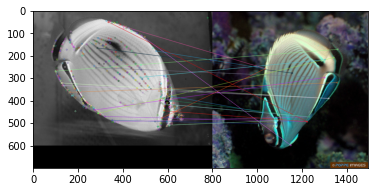

(<matplotlib.image.AxesImage at 0x7f599c187350>, None)

In [21]:
#image 2
img2 = cv.imread('../catchafish/data/fish_05/922294.jpg')
sift = cv.xfeatures2d.SIFT_create()
keypoints_2, descriptors_2 = sift.detectAndCompute(img2,None)
img_2 = cv.drawKeypoints(gray2,keypoints_2,img2)


# BFMatcher with default params
bf = cv.BFMatcher()
matches = bf.knnMatch(descriptors_1,descriptors_2,k=2)
# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append([m])
# cv.drawMatchesKnn expects list of lists as matches.
img3 = cv.drawMatchesKnn(img1,keypoints_1,img2,keypoints_2,good,None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img3),plt.show()

Version of google colab here : https://colab.research.google.com/drive/19cPiYaGkczfUe-CrSaAoAPaTHzZW7Fv8?usp=sharing

# EXTRACTING ALL KEYPOINTS FROM DATASET

In [25]:
def extract_keypoints(img):
    img = cv.imread(img)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    sift = cv.xfeatures2d.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(img,None)
    return descriptors

def extracting_keypoints_dataset():
    import os.path
    path = '../catchafish/data/train_data'
    classe = 0
    X = []
    for root, dirs, files in os.walk(path):
        for i in files:
            img = os.path.join(root, i) 
            img_keypoints = extract_keypoints(img)
            for img_keypoint in img_keypoints:
                X.append(img_keypoint)
    return np.array(X)

In [26]:
X_k = extracting_keypoints_dataset()

# FIT KMEANS FOR CLUSTER

In [27]:
from sklearn.cluster import KMeans
n_clusters = 30
kmeans = KMeans(n_clusters=n_clusters).fit(X_k)

# MATCH EACH KEYPOINTS TO A CLUSTER

In [28]:
def matching_keypoints_dataset(n_images,n_clusters,path = '../catchafish/data/train_data'):
    X = np.zeros((n_images,n_clusters))
    import os.path
    classe = 0
    nom_dossier = ''
    y = []
    index_image = 0
    for root, dirs, files in os.walk(path):
        if nom_dossier == '':
            nom_dossier = root
        elif nom_dossier != root:
            nom_dossier = root
            classe = classe + 1
        for i in files:
            img = os.path.join(root, i) 
            img_keypoints = extract_keypoints(img)
            for img_keypoint in img_keypoints:
                cluster = kmeans.predict(img_keypoint.reshape(1, -1))
                X[index_image,cluster] = 1
            index_image +=1
            y.append(classe)
    return X, np.array(y)

In [29]:
n_images = 566 #nombre d'images total
X,y = matching_keypoints_dataset(n_images,n_clusters)

# DATA PREPROCESSING

In [30]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

# GRIDSEARCH SVC

In [31]:
param_grid = { "C" : [1,10,15], "kernel" : ["linear", "rbf", "poly", "sigmoid"]}
svcgrid = GridSearchCV(estimator = SVC(),
                       param_grid = param_grid,
                      cv = 5,
                      scoring = 'accuracy')
svcgrid.fit(X, y)
svcgrid.best_score_

/home/lilahammer/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/lilahammer/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/lilahammer/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid

/home/lilahammer/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/lilahammer/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/lilahammer/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid

0.13427561837455831

In [33]:
from joblib import dump, load
dump(svcgrid.best_estimator_, 'model_keypoints.joblib') 

['model_keypoints.joblib']



# BONUS SAVE IMAGE AUGMENTATION

In [7]:
def create_new_data(val_split = False, val_size = 0.3, zca_whitening = False):
    path = '../../data_set_augmented'
    batch_size = 1500
    dir_iterator = DirectoryIterator(directory = path,
                                     image_data_generator = None,
                                     target_size = (128, 128),
                                     batch_size = batch_size,
                                     shuffle = False,
                                     dtype = int)
    X = dir_iterator[0][0] #/ 255
    y = dir_iterator.labels
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)
    image_data_generator = ImageDataGenerator(zca_whitening = zca_whitening,
                                              rotation_range = 5,
                                              width_shift_range = 0.3,
                                              height_shift_range = 0.3,
                                              shear_range = 0.3,
                                              zoom_range = 0.3,
                                              horizontal_flip = True,
                                              fill_mode = 'nearest')
    
    image_data_generator.fit(X_train)
#save_to_dir='../catchafish/data/new_data/'
    extended_output = []
    for images in image_data_generator.flow(X_train, y_train, batch_size = batch_size,save_to_dir='../../data_set_augmented/',
    save_prefix="aug_",
    save_format="jpeg"):
        extended_output.append(images)
        if len(extended_output) == 5:
            break


In [8]:
create_new_data()

Found 566 images belonging to 11 classes.
